In [1]:
import random
import torch
from torch import nn

import triton

#from egs.baselines import TorchGatherEinsum, TorchLinearGather, TorchEinsumScatter
from egs.baselines import TorchLinearGather, TorchEinsumScatter
from egs.baselines import TorchReshapedGatherEinsum as TorchGatherEinsum
from egs import ExpertGather, ExpertScatter

def is_cuda():
    return triton.runtime.driver.active.get_current_target().backend == "cuda"
ref_lib = 'cuBLAS' if is_cuda() else 'rocBLAS'

seed = 42

random.seed(seed)
torch.manual_seed(seed)

In [2]:
def gather_benchmark_speed(T, B, E, J, I, K, provider, fp8_inputs):
    quantiles = [0.5, 0.2, 0.8]

    DEVICE = "cuda"  
    
    X = torch.randn((B, T, I), device=DEVICE, dtype=torch.float32, requires_grad=True)
    W = torch.randn((E, I, J), device=DEVICE, dtype=torch.float32, requires_grad=True)
    kernel_head_projection = ExpertGather(E, I, J).to(DEVICE)

    torch_einsum_head_projection = TorchGatherEinsum(E, I, J).to(DEVICE)
    torch_einsum_head_projection.W = nn.Parameter(kernel_head_projection.W)

    Ind = torch.randint(0, T-1, (B, E, K), device=DEVICE, dtype=torch.int16, requires_grad=False)
    Ind64 = Ind.to(torch.int64)

    if provider == 'torch':
        def run():
            Y_torch = torch_einsum_head_projection(X, Ind64)
            l = Y_torch.sum()
            l.backward()
        ms, min_ms, max_ms = triton.testing.do_bench(run, quantiles=quantiles)
    elif provider == "egs":
        def run():
            Y_esg = kernel_head_projection(X, Ind)
            l = Y_esg.sum()
            l.backward()
        ms, min_ms, max_ms = triton.testing.do_bench(run, quantiles=quantiles)
    else:
        raise ValueError(f"Unknown provider: {provider}")

    return ms, max_ms, min_ms

def gather_benchmark_memory(T, B, E, J, I, K, provider, fp8_inputs):
    quantiles = [0.5, 0.2, 0.8]

    DEVICE = "cuda" 
    
    X = torch.randn((B, T, I), device=DEVICE, dtype=torch.float32, requires_grad=True)
    W = torch.randn((E, I, J), device=DEVICE, dtype=torch.float32, requires_grad=True)
    kernel_head_projection = ExpertGather(E, I, J).to(DEVICE)

    torch_einsum_head_projection = TorchGatherEinsum(E, I, J).to(DEVICE)
    torch_einsum_head_projection.W = nn.Parameter(kernel_head_projection.W)

    Ind = torch.randint(0, T-1, (B, E, K), device=DEVICE, dtype=torch.int16, requires_grad=False)
    Ind64 = Ind.to(torch.int64)
    torch.cuda.reset_peak_memory_stats()
    if provider == 'torch':
        def run():
            Y_torch = torch_einsum_head_projection(X, Ind64)
            l = Y_torch.sum()
            l.backward()
        triton.testing.do_bench(run, quantiles=quantiles)
    elif provider == "egs":
        def run():
            Y_esg = kernel_head_projection(X, Ind)
            l = Y_esg.sum()
            l.backward()
        triton.testing.do_bench(run, quantiles=quantiles)
    else:
        raise ValueError(f"Unknown provider: {provider}")
    memory_used = torch.cuda.max_memory_allocated() / (1024 ** 2)

    return memory_used, memory_used, memory_used

def scatter_benchmark_speed(T, B, E, J, I, K, provider, fp8_inputs):
    quantiles = [0.5, 0.2, 0.8]

    DEVICE = "cuda"  
    
    Y = torch.randn((B, E, K, J), device=DEVICE, dtype=torch.float32, requires_grad=True)
    kernel_head_projection = ExpertScatter(E, J, I).to(DEVICE)

    torch_einsum_head_projection = TorchEinsumScatter(E, J, I).to(DEVICE)
    torch_einsum_head_projection.W = nn.Parameter(kernel_head_projection.W)

    Ind = torch.randint(0, T-1, (B, E, K), device=DEVICE, dtype=torch.int16, requires_grad=False)
    Ind64 = Ind.to(torch.int64)

    if provider == 'torch':
        def run():
            X_torch = torch_einsum_head_projection(Y, Ind64, T)
            l = X_torch.sum()
            l.backward()
        ms, min_ms, max_ms = triton.testing.do_bench(run, quantiles=quantiles)
    elif provider == "egs":
        def run():
            X_esg = kernel_head_projection(Y, Ind, T)
            l = X_esg.sum()
            l.backward()
        ms, min_ms, max_ms = triton.testing.do_bench(run, quantiles=quantiles)
    else:
        raise ValueError(f"Unknown provider: {provider}")
    
    return ms, max_ms, min_ms
    
def scatter_benchmark_memory(T, B, E, J, I, K, provider, fp8_inputs):
    quantiles = [0.5, 0.2, 0.8]

    DEVICE = "cuda"  
    
    Y = torch.randn((B, E, K, J), device=DEVICE, dtype=torch.float32, requires_grad=True)
    kernel_head_projection = ExpertScatter(E, J, I).to(DEVICE)

    torch_einsum_head_projection = TorchEinsumScatter(E, J, I).to(DEVICE)
    torch_einsum_head_projection.W = nn.Parameter(kernel_head_projection.W)

    Ind = torch.randint(0, T-1, (B, E, K), device=DEVICE, dtype=torch.int16, requires_grad=False)
    Ind64 = Ind.to(torch.int64)

    torch.cuda.reset_peak_memory_stats()
    if provider == 'torch':
        def run():
            X_torch = torch_einsum_head_projection(Y, Ind64, T)
            l = X_torch.sum()
            l.backward()
        triton.testing.do_bench(run, quantiles=quantiles)
    elif provider == "egs":
        def run():
            X_esg = kernel_head_projection(Y, Ind, T)
            l = X_esg.sum()
            l.backward()
        triton.testing.do_bench(run, quantiles=quantiles)
    else:
        raise ValueError(f"Unknown provider: {provider}")
    memory_used = torch.cuda.max_memory_allocated() / (1024 ** 2)

    return memory_used, memory_used, memory_used

In [3]:
# Default config
E = 32 # Number of experts
T = 256 # Sequence length
K = 32 # Number of tokens to process by each expert
B = 64 # Batch size
J = 64 # Number of dimensions for the output of gather and input of scatter
I = 128 # Number of dimensions for the input of gather and output of scatter

# Scaling with T 

ratio T / K is important for the performance benefits. For sparse gathers egs avoids unnecessarily computed large matrices.

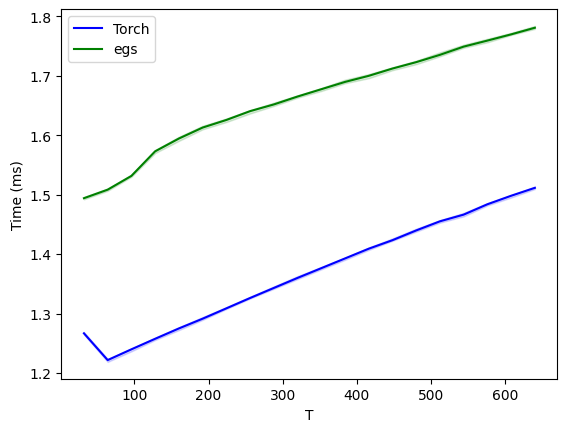

time needed for a forward and a backward pass:
        T     Torch       egs
0    32.0  1.266688  1.494016
1    64.0  1.221632  1.508352
2    96.0  1.239776  1.531536
3   128.0  1.257472  1.572864
4   160.0  1.274880  1.594368
5   192.0  1.291264  1.612800
6   224.0  1.308672  1.625600
7   256.0  1.326080  1.640448
8   288.0  1.342976  1.651712
9   320.0  1.359872  1.665024
10  352.0  1.376256  1.677312
11  384.0  1.392640  1.689600
12  416.0  1.409024  1.699840
13  448.0  1.423360  1.712128
14  480.0  1.439744  1.722880
15  512.0  1.455104  1.735168
16  544.0  1.466368  1.748992
17  576.0  1.483776  1.759136
18  608.0  1.498112  1.769600
19  640.0  1.511424  1.780736


In [4]:


configs = [
    triton.testing.Benchmark(
        x_names=["T"],
        x_vals=[32 * i + 32 for i in range(20)],
        line_arg="provider",
        line_vals=["torch", "egs"],
        line_names=["Torch", "egs"],
        styles=[ ("blue", "-"), ("green", "-")],
        ylabel="Time (ms)",
        plot_name="time needed for a forward and a backward pass",
        args={
            "fp8_inputs": False,
            "B": B, "E": E, "J": J, "I": I, "K": K
            },
    )
]
triton.testing.perf_report(configs)(gather_benchmark_speed).run(show_plots=True, print_data=True)

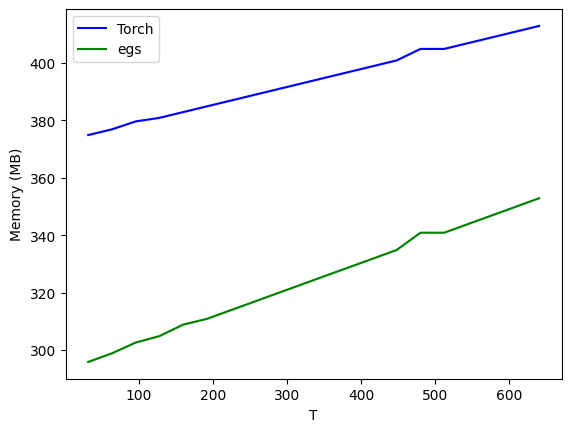

MBs required to complete a forward and a backward pass:
        T       Torch         egs
0    32.0  374.875977  295.875977
1    64.0  376.875977  298.875977
2    96.0  379.625977  302.625977
3   128.0  380.875977  304.875977
4   160.0  382.875977  308.875977
5   192.0  384.875977  310.875977
6   224.0  386.875977  313.875977
7   256.0  388.875977  316.875977
8   288.0  390.875977  319.875977
9   320.0  392.875977  322.875977
10  352.0  394.875977  325.875977
11  384.0  396.875977  328.875977
12  416.0  398.875977  331.875977
13  448.0  400.875977  334.875977
14  480.0  404.875977  340.875977
15  512.0  404.875977  340.875977
16  544.0  406.875977  343.875977
17  576.0  408.875977  346.875977
18  608.0  410.875977  349.875977
19  640.0  412.875977  352.875977


In [5]:

configs = [
    triton.testing.Benchmark(
        x_names=["T"],
        x_vals=[32 * i + 32 for i in range(20)],
        line_arg="provider",
        line_vals=["torch", "egs"],
        line_names=["Torch", "egs"],
        styles=[ ("blue", "-"), ("green", "-")],
        ylabel="Memory (MB)",
        plot_name="MBs required to complete a forward and a backward pass",
        args={
            "fp8_inputs": False,
            "B": B, "E": E, "J": J, "I": I, "K": K
            },
    )
]
triton.testing.perf_report(configs)(gather_benchmark_memory).run(show_plots=True, print_data=True)

# Scaling with E 

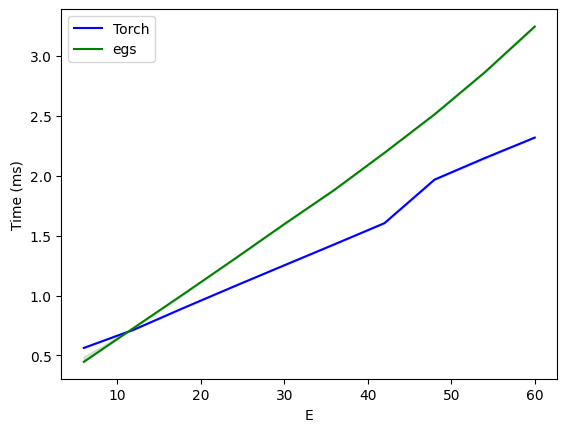

time needed for a forward and a backward pass:
      E     Torch       egs
0   6.0  0.563200  0.447488
1  12.0  0.715776  0.731136
2  18.0  0.898048  1.014784
3  24.0  1.076224  1.302528
4  30.0  1.251696  1.594752
5  36.0  1.426432  1.880064
6  42.0  1.603072  2.189312
7  48.0  1.966080  2.509824
8  54.0  2.145280  2.859520
9  60.0  2.316288  3.241984


In [6]:


configs = [
    triton.testing.Benchmark(
        x_names=["E"],
        x_vals=[6 * (i+1) for i in range(10)],
        line_arg="provider",
        line_vals=["torch", "egs"],
        line_names=["Torch", "egs"],
        styles=[ ("blue", "-"), ("green", "-")],
        ylabel="Time (ms)",
        plot_name="time needed for a forward and a backward pass",
        args={
            "fp8_inputs": False,
            "B": B,"J": J, "I": I, "K": K, "T": T
            },
    )
]
triton.testing.perf_report(configs)(gather_benchmark_speed).run(show_plots=True, print_data=True)

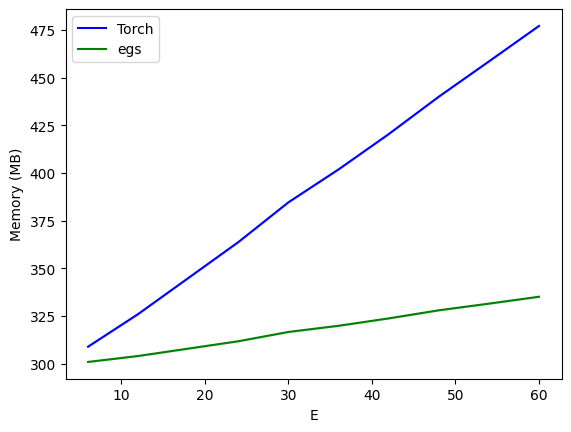

MBs required to complete a forward and a backward pass:
      E       Torch         egs
0   6.0  308.868164  300.868164
1  12.0  325.985352  303.985352
2  18.0  344.852539  307.852539
3  24.0  363.719727  311.719727
4  30.0  384.586914  316.586914
5  36.0  401.829102  319.829102
6  42.0  420.321289  323.696289
7  48.0  439.938477  327.938477
8  54.0  458.430664  331.430664
9  60.0  477.047852  335.047852


In [7]:
configs = [
    triton.testing.Benchmark(
        x_names=["E"],
        x_vals=[6 * (i+1) for i in range(10)],
        line_arg="provider",
        line_vals=["torch", "egs"],
        line_names=["Torch", "egs"],
        styles=[ ("blue", "-"), ("green", "-")],
        ylabel="Memory (MB)",
        plot_name="MBs required to complete a forward and a backward pass",
        args={
            "fp8_inputs": False,
            "B": B,"J": J, "I": I, "K": K, "T": T
            },
    )
]
triton.testing.perf_report(configs)(gather_benchmark_memory).run(show_plots=True, print_data=True)

# Scaling with B

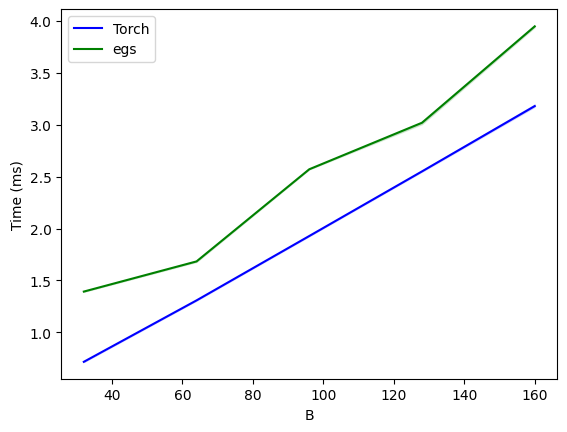

time needed for a forward and a backward pass:
       B     Torch       egs
0   32.0  0.715776  1.392640
1   64.0  1.307776  1.683360
2   96.0  1.928192  2.571264
3  128.0  2.550784  3.019776
4  160.0  3.180352  3.948544


In [8]:

configs = [
    triton.testing.Benchmark(
        x_names=["B"],
        x_vals=[32 * (i+1) for i in range(5)],
        line_arg="provider",
        line_vals=["torch", "egs"],
        line_names=["Torch", "egs"],
        styles=[ ("blue", "-"), ("green", "-")],
        ylabel="Time (ms)",
        plot_name="time needed for a forward and a backward pass",
        args={
            "fp8_inputs": False,
            "E":E, "J": J, "I": I, "K": K, "T": T
            },
    )
]
triton.testing.perf_report(configs)(gather_benchmark_speed).run(show_plots=True, print_data=True)

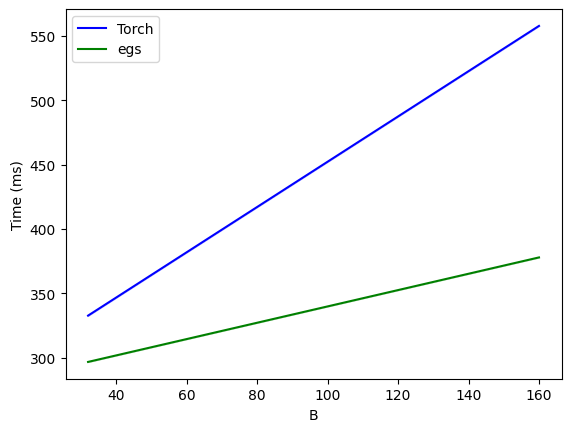

time needed for a forward and a backward pass:
       B       Torch         egs
0   32.0  332.563477  296.563477
1   64.0  388.875977  316.875977
2   96.0  445.188477  337.188477
3  128.0  501.500977  357.500977
4  160.0  557.813477  377.813477


In [9]:
configs = [
    triton.testing.Benchmark(
        x_names=["B"],
        x_vals=[32 * (i+1) for i in range(5)],
        line_arg="provider",
        line_vals=["torch", "egs"],
        line_names=["Torch", "egs"],
        styles=[ ("blue", "-"), ("green", "-")],
        ylabel="Time (ms)",
        plot_name="time needed for a forward and a backward pass",
        args={
            "fp8_inputs": False,
            "E":E, "J": J, "I": I, "K": K, "T": T
            },
    )
]
triton.testing.perf_report(configs)(gather_benchmark_memory).run(show_plots=True, print_data=True)

# Scaling with I

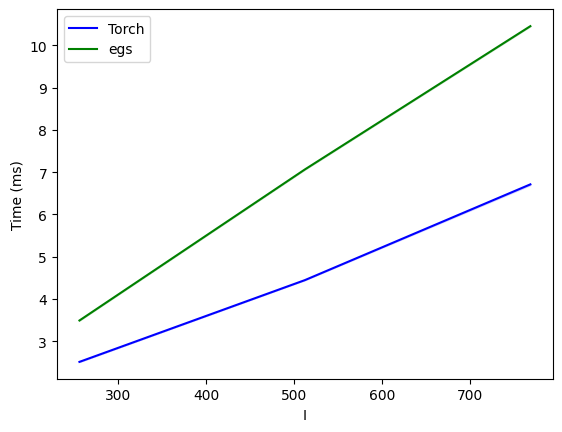

time needed for a forward and a backward pass:
       I     Torch        egs
0  256.0  2.513920   3.492352
1  512.0  4.447232   7.064176
2  768.0  6.711296  10.451968


In [10]:

configs = [
    triton.testing.Benchmark(
        x_names=["I"],
        x_vals=[256 * (i+1) for i in range(3)],
        line_arg="provider",
        line_vals=["torch", "egs"],
        line_names=["Torch", "egs"],
        styles=[ ("blue", "-"), ("green", "-")],
        ylabel="Time (ms)",
        plot_name="time needed for a forward and a backward pass",
        args={
            "fp8_inputs": False,
            "B": B, "E":E, "J": J, "K": K, "T": T
            },
    )
]
triton.testing.perf_report(configs)(gather_benchmark_speed).run(show_plots=True, print_data=True)

In [11]:
# Increasing I increases the benefits of the better optimised matrix multiplication, so the sparsity has to be higher in order to observe time benefits

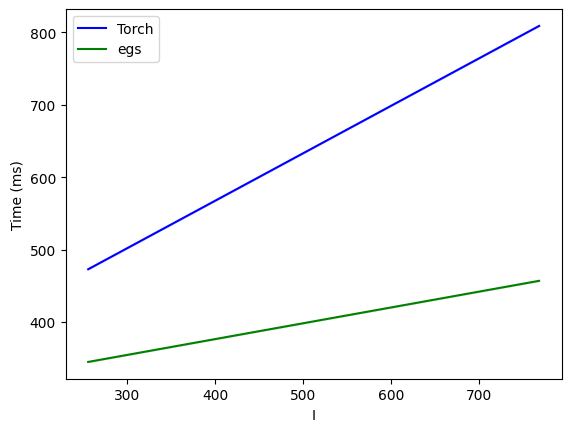

time needed for a forward and a backward pass:
       I       Torch         egs
0  256.0  472.875977  344.875977
1  512.0  640.875977  400.875977
2  768.0  808.875977  456.875977


In [12]:
configs = [
    triton.testing.Benchmark(
        x_names=["I"],
        x_vals=[256 * (i+1) for i in range(3)],
        line_arg="provider",
        line_vals=["torch", "egs"],
        line_names=["Torch", "egs"],
        styles=[ ("blue", "-"), ("green", "-")],
        ylabel="Time (ms)",
        plot_name="time needed for a forward and a backward pass",
        args={
            "fp8_inputs": False,
            "B": B, "E":E, "J": J, "K": K, "T": T
            },
    )
]
triton.testing.perf_report(configs)(gather_benchmark_memory).run(show_plots=True, print_data=True)

# Scatter

Scatter profiling for compound forward and backward is essentially identical to gather, because forward operations from gather correspond to backward operations from scatter and vice versa. Specifically 
 - Y=Gather(X) corresponds to X_grad=scatter_gradX(Y_grad)
 - X=Scatter(Y) corresponds to Y_grad=gather_gradY(X_grad)
 - scatter_gradW corresponds to gather_gradW

For more details check out the implementations of each function in egs.triton_kernels

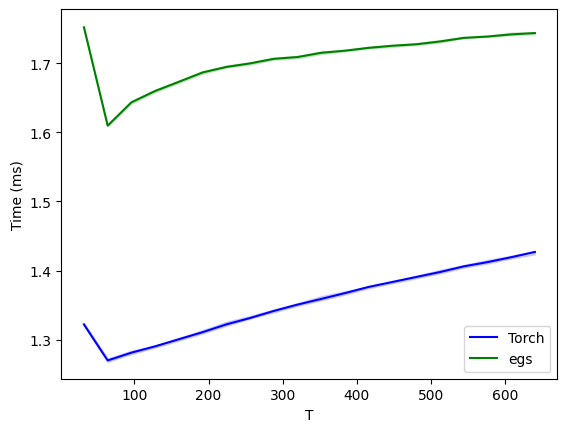

time needed for a forward and a backward pass:
        T     Torch       egs
0    32.0  1.321984  1.752064
1    64.0  1.269760  1.609728
2    96.0  1.281024  1.643520
3   128.0  1.290240  1.659904
4   160.0  1.300480  1.673216
5   192.0  1.310720  1.686752
6   224.0  1.321984  1.694720
7   256.0  1.331200  1.699840
8   288.0  1.341440  1.706496
9   320.0  1.350656  1.709056
10  352.0  1.358848  1.715200
11  384.0  1.367296  1.718272
12  416.0  1.376256  1.722368
13  448.0  1.383424  1.725440
14  480.0  1.390592  1.727488
15  512.0  1.397760  1.731584
16  544.0  1.405952  1.736704
17  576.0  1.412096  1.738752
18  608.0  1.419216  1.741824
19  640.0  1.426832  1.743792


In [13]:
E = 32 # Number of experts
T = 128 # Sequence length
K = 32 # Number of tokens to process by each expert
B = 64 # Batch size
J = 64 # Number of dimensions for the output of gather and input of scatter
I = 128 # Number of dimensions for the input of gather and output of scatter

configs = [
    triton.testing.Benchmark(
        x_names=["T"],
        x_vals=[32 * i + 32 for i in range(20)],
        line_arg="provider",
        line_vals=["torch", "egs"],
        line_names=["Torch", "egs"],
        styles=[ ("blue", "-"), ("green", "-")],
        ylabel="Time (ms)",
        plot_name="time needed for a forward and a backward pass",
        args={
            "fp8_inputs": False,
            "B": B, "E": E, "J": J, "I": I, "K": K
            },
    )
]
triton.testing.perf_report(configs)(scatter_benchmark_speed).run(show_plots=True, print_data=True)

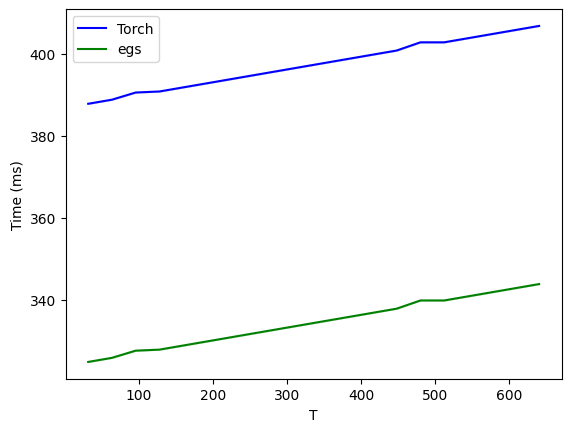

time needed for a forward and a backward pass:
        T       Torch         egs
0    32.0  387.875977  324.875977
1    64.0  388.875977  325.875977
2    96.0  390.625977  327.625977
3   128.0  390.875977  327.875977
4   160.0  391.875977  328.875977
5   192.0  392.875977  329.875977
6   224.0  393.875977  330.875977
7   256.0  394.875977  331.875977
8   288.0  395.875977  332.875977
9   320.0  396.875977  333.875977
10  352.0  397.875977  334.875977
11  384.0  398.875977  335.875977
12  416.0  399.875977  336.875977
13  448.0  400.875977  337.875977
14  480.0  402.875977  339.875977
15  512.0  402.875977  339.875977
16  544.0  403.875977  340.875977
17  576.0  404.875977  341.875977
18  608.0  405.875977  342.875977
19  640.0  406.875977  343.875977


In [14]:

configs = [
    triton.testing.Benchmark(
        x_names=["T"],
        x_vals=[32 * i + 32 for i in range(20)],
        line_arg="provider",
        line_vals=["torch", "egs"],
        line_names=["Torch", "egs"],
        styles=[ ("blue", "-"), ("green", "-")],
        ylabel="Time (ms)",
        plot_name="time needed for a forward and a backward pass",
        args={
            "fp8_inputs": False,
            "B": B, "E": E, "J": J, "I": I, "K": K
            },
    )
]
triton.testing.perf_report(configs)(scatter_benchmark_memory).run(show_plots=True, print_data=True)